![title.png](ML_09.png)

# Agenda

## 1. Clustering task
## 2. K-means intuition
## 3. Elbow method
## 4. Hierarchical clustering intuition
## 5. DBScan intuition
## 6. Gaussian Mixture intuition

## 1. Clustering Task

Clustering is an unsupervised learning task where the aim is to group similar data points together. Unlike supervised learning, there are no labels. The goal is to find structure in data, identifying patterns, or segmenting datasets into groups (clusters) based on similarity metrics like Euclidean distance.

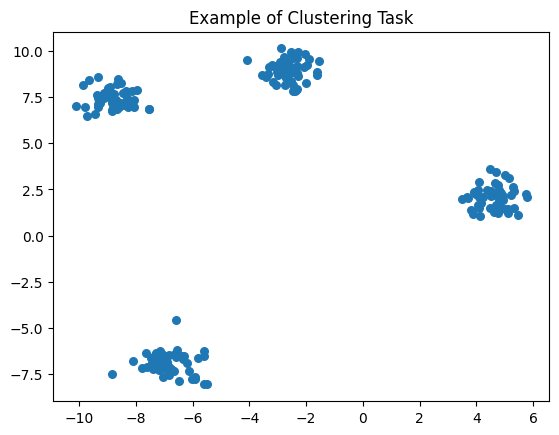

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=200, centers=4, cluster_std=0.6, random_state=42)
plt.scatter(X[:,0], X[:,1], s=30)
plt.title("Example of Clustering Task")
plt.show()

**Practical Use:** Clustering is used in:
- customer segmentation (helps to understand customer groups better and tailor marketing according to those segments),
- anomaly detection (Normal behavior forms dense clusters. Outliers — points far from any cluster — are potential anomalies),
- document organization (It enables automatic grouping without predefined categories — the system discovers topics from the data itself, making browsing and recommendation more efficient)

## 2. K-Means Intuition

K-Means is a popular clustering algorithm that partitions the data into K clusters by minimizing the variance within each cluster. It starts by initializing K centroids, assigns each data point to the nearest centroid, and then updates the centroids based on the mean of the assigned points until convergence.

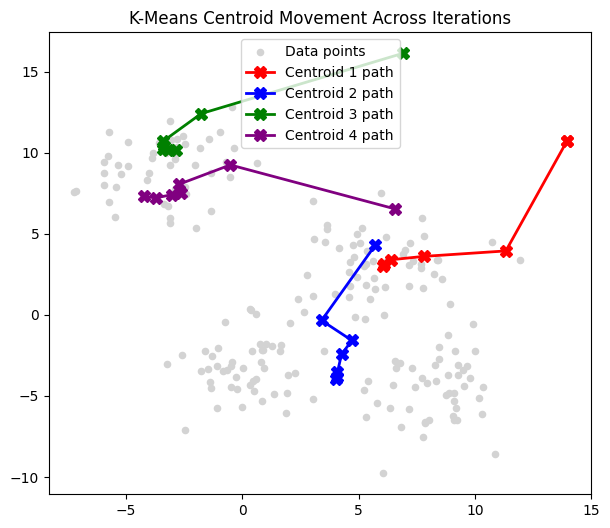

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

# Generate more overlapping clusters
X, _ = make_blobs(n_samples=200, centers=4, cluster_std=1.8, random_state=4242)

K = 4
max_iterations = 6

# Start with very bad centroid positions (chosen from random points far away)
rng = np.random.RandomState(4)
initial_centroids = X[rng.choice(len(X), K, replace=False)] + rng.uniform(5, 10, (K, X.shape[1]))

centroids_history = [initial_centroids]
centroids = initial_centroids.copy()

for _ in range(max_iterations):
    # Assign points to nearest centroid
    labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
    # Compute new centroids
    new_centroids = np.array([X[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i]
                              for i in range(K)])
    centroids_history.append(new_centroids)
    centroids = new_centroids

centroids_history = np.array(centroids_history)

# Plot trajectory of centroids
plt.figure(figsize=(7, 6))
plt.scatter(X[:, 0], X[:, 1], c='lightgray', s=20, label="Data points")

colors = ['red', 'blue', 'green', 'purple']
for i in range(K):
    plt.plot(centroids_history[:, i, 0], centroids_history[:, i, 1], marker='X', markersize=8,
             color=colors[i], linewidth=2, label=f'Centroid {i+1} path')

plt.title("K-Means Centroid Movement Across Iterations")
plt.legend()
plt.show()


**Practical Use:** K-Means can be used in market segmentation, and recommendation systems (Item-based recommendation, user-based recomendations)

## 3. Elbow Method

The Elbow Method is a heuristic to choose the optimal number of clusters for K-Means. It involves running K-Means with different values of K and plotting the sum of squared errors (SSE). The 'elbow' point, where SSE starts decreasing more slowly, suggests the best K.

Elbow method suggests k = 3


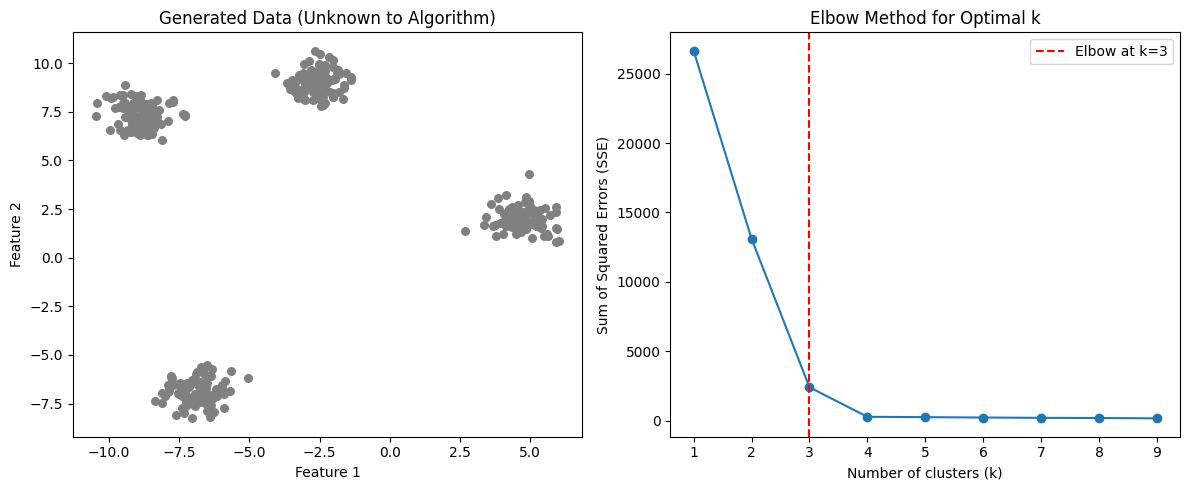

In [6]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from kneed import KneeLocator

# Generate dataset
X, _ = make_blobs(n_samples=400, centers=4, cluster_std=0.6, random_state=42)

# Calculate SSE for different k
K_values = range(1, 10)
sse = []
for k in K_values:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    sse.append(km.inertia_)

# Find optimal k using KneeLocator
kl = KneeLocator(K_values, sse, curve='convex', direction='decreasing')
optimal_k = kl.knee
print(f"Elbow method suggests k = {optimal_k}")

# Plot side-by-side: dataset & elbow plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: raw data
axes[0].scatter(X[:, 0], X[:, 1], s=30, color='gray')
axes[0].set_title("Generated Data (Unknown to Algorithm)")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# Right: elbow plot
axes[1].plot(K_values, sse, marker='o')
axes[1].axvline(optimal_k, color='red', linestyle='--', label=f"Elbow at k={optimal_k}")
axes[1].set_title("Elbow Method for Optimal k")
axes[1].set_xlabel("Number of clusters (k)")
axes[1].set_ylabel("Sum of Squared Errors (SSE)")
axes[1].legend()

plt.tight_layout()
plt.show()


### Elbow Method — Limitations in Practice

The Elbow Method looks for the point where adding more clusters stops giving large SSE reductions.  
However:

- The “elbow” isn’t always clear or well-defined.  
- Different people may see the “elbow” at different points.  
- Automated methods (like `KneeLocator`) can misidentify it, especially if the curve flattens gradually.  
- In high-dimensional or noisy data, there might be no clear elbow at all.

In this example, `KneeLocator` suggests **k = 3**, while we know the data was generated with **4 clusters**.  
This discrepancy shows that the elbow method is a **heuristic**, not a guarantee — and why we should combine it with:

- Domain knowledge (what’s reasonable for the problem)  
- Visual inspection of clusters  
- Other metrics (e.g., Silhouette score, Davies–Bouldin index)


## 4. Hierarchical Clustering Intuition

Hierarchical clustering builds a hierarchy of clusters either through agglomerative (bottom-up) or divisive (top-down) approaches. Agglomerative clustering starts with each data point as its own cluster and merges the closest clusters until one remains.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
import ipywidgets as widgets
from IPython.display import display

# Generate dataset
X, _ = make_blobs(n_samples=15, centers=3, cluster_std=0.8, random_state=42)

# Precompute all clustering steps
clusters_steps = []

# Step 0: each point is its own cluster
clusters = {i: [i] for i in range(len(X))}
clusters_steps.append(clusters.copy())

# Iteratively merge clusters
for _ in range(len(X) - 1):
    centroids = np.array([X[indices].mean(axis=0) for indices in clusters.values()])
    dist_matrix = squareform(pdist(centroids))
    np.fill_diagonal(dist_matrix, np.inf)
    i, j = np.unravel_index(np.argmin(dist_matrix), dist_matrix.shape)
    keys = list(clusters.keys())
    clusters[keys[i]] += clusters[keys[j]]
    del clusters[keys[j]]
    clusters_steps.append(clusters.copy())

# Function to plot a specific step
def plot_step(step):
    plt.figure(figsize=(5, 4))
    colors = plt.cm.tab10(np.arange(len(clusters_steps[step])) % 10)
    for color, indices in zip(colors, clusters_steps[step].values()):
        plt.scatter(X[indices, 0], X[indices, 1], s=100, c=[color], edgecolors='k')
    plt.title(f'Hierarchical Clustering Step {step}')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Interactive slider
slider = widgets.IntSlider(min=0, max=len(clusters_steps)-1, step=1, value=0, description='Step:')
widgets.interact(plot_step, step=slider)


interactive(children=(IntSlider(value=0, description='Step:', max=14), Output()), _dom_classes=('widget-intera…

<function __main__.plot_step(step)>

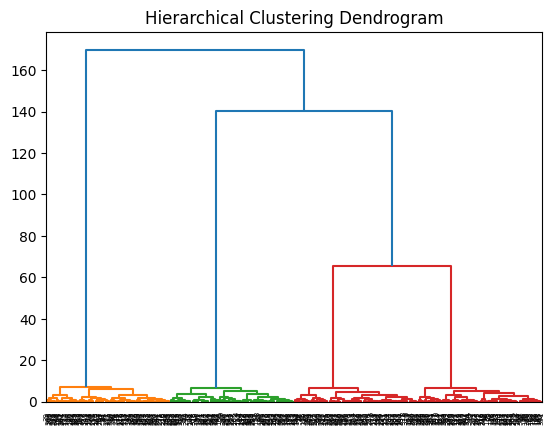

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(X, 'ward')
dendrogram(linked)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

### Hierarchical Clustering Approaches — Real-World Examples

Hierarchical clustering can be performed in two main ways: **agglomerative (bottom-up)** and **divisive (top-down)**.

---

#### 1. Agglomerative Clustering (Bottom-Up)

**Definition:**  
Agglomerative clustering starts with each data point as its own cluster and repeatedly merges the two closest clusters until all points belong to one cluster or a stopping criterion is met.

**Real-world example: Gene Expression Analysis**  
- **Problem:** A biologist wants to identify groups of genes that are co-expressed across different tissue samples. Each gene is represented by a vector of expression levels.  
- **Why agglomerative clustering is crucial:**  
  - The number of natural gene clusters is unknown.  
  - The method produces a **dendrogram**, showing relationships at multiple levels.  
  - Cutting the dendrogram at different heights allows exploration of coarse vs. fine-grained groupings.  
- **Impact:** Identifies potential gene interactions, reveals underlying biological pathways, and helps guide drug target discovery.

---

#### 2. Divisive Clustering (Top-Down)

**Definition:**  
Divisive clustering starts with all data points in a single cluster and recursively splits clusters into smaller clusters until a stopping condition is reached.

**Real-world example: Social Network Analysis**  
- **Problem:** A social media platform wants to identify communities of users within a large network. Users are nodes and friendships are edges.  
- **Why divisive clustering is crucial:**  
  - Major community divisions are identified first.  
  - Nested sub-communities are revealed through recursive splitting.  
  - Useful when a global view of the network is needed before looking at finer structures.  
- **Impact:** Supports targeted content recommendations, marketing campaigns, moderation strategies, and detection of influence hubs.

---

**Key Takeaways:**  
- **Agglomerative:** Best for exploring fine relationships first and merging step by step (e.g., gene clusters).  
- **Divisive:** Best when major divisions matter first and finer splits come later (e.g., social network communities).  
- Both methods produce **interpretable hierarchical structures**, which is a major advantage over flat clustering methods like K-Means.


### Question time!

## DBSCAN Intuition

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points that are closely packed together, marking points in low-density regions as outliers. It does not require specifying the number of clusters and can find arbitrarily shaped clusters.

<Figure size 600x500 with 0 Axes>

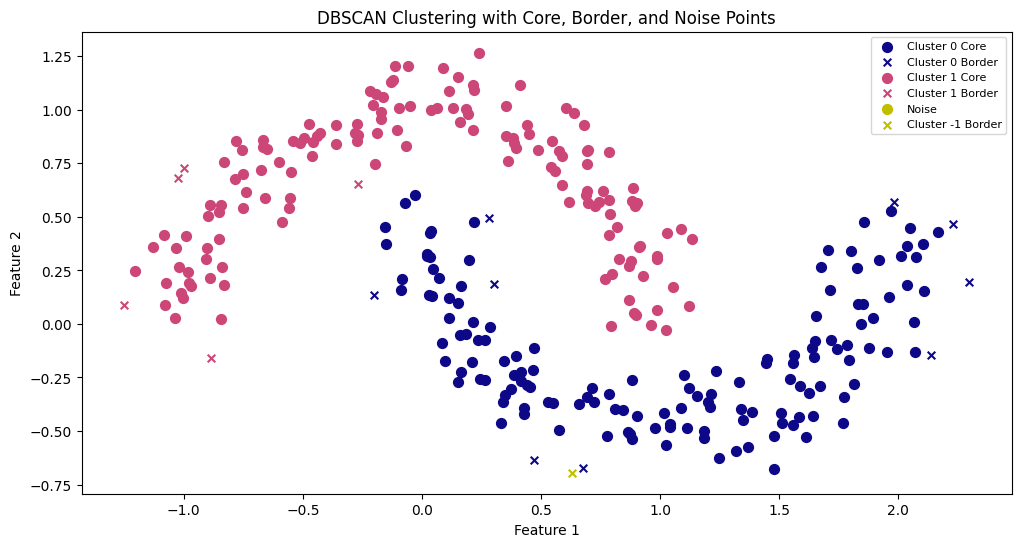

In [18]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Generate dataset
X, _ = make_moons(n_samples=300, noise=0.11, random_state=42)

# Fit DBSCAN
db = DBSCAN(eps=0.2, min_samples=5)
labels = db.fit_predict(X)

# Core samples
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

plt.figure(figsize=(6,5))
unique_labels = set(labels)
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(12, 6))  # 12 inches wide, 6 inches tall


for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points
        col = 'y'
    class_member_mask = (labels == k)
    # Core points
    xy_core = X[class_member_mask & core_samples_mask]
    plt.scatter(xy_core[:, 0], xy_core[:, 1], s=50, c=[col], marker='o', label=f'Cluster {k} Core' if k != -1 else 'Noise')
    # Border points
    xy_border = X[class_member_mask & ~core_samples_mask]
    if xy_border.size > 0:
        plt.scatter(xy_border[:, 0], xy_border[:, 1], s=30, c=[col], marker='x', label=f'Cluster {k} Border')

plt.title("DBSCAN Clustering with Core, Border, and Noise Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc='best', fontsize=8)
plt.show()


### DBSCAN Use Cases and Why It’s Well-Suited

DBSCAN is a density-based clustering algorithm that is particularly effective in scenarios where clusters have **arbitrary shapes**, noise is present, and the number of clusters is unknown. Some real-world use cases include:

---

#### 1. Anomaly Detection

**Problem:**  
- Identify outliers in datasets such as fraud detection, network intrusion, or sensor readings.  

**Why DBSCAN works well:**  
- Naturally labels **noise points** that do not belong to any cluster.  
- Does not require specifying the number of clusters in advance.  
- Outliers are usually in **low-density regions**, which DBSCAN marks as `-1`.  

**Example:**  
- Credit card transactions: normal transactions form dense clusters, while fraudulent transactions are isolated and detected as noise.  

---

#### 2. Geographical Data Clustering

**Problem:**  
- Group nearby geographical locations, e.g., restaurants, crime incidents, or earthquake epicenters.  

**Why DBSCAN works well:**  
- Detects **arbitrary-shaped clusters** (e.g., clusters along rivers or streets).  
- Ignores isolated points as noise.  
- No need to pre-specify the number of clusters.  

**Example:**  
- Clustering taxi pickups to identify high-demand zones in a city. DBSCAN finds dense areas without assuming how many zones exist.  

---

#### 3. Image Segmentation

**Problem:**  
- Group pixels in an image based on color, intensity, or texture to identify meaningful regions.  

**Why DBSCAN works well:**  
- Handles regions of **varying density** (solid objects vs. textured backgrounds).  
- Detects small artifacts as noise.  
- Works with **arbitrary-shaped clusters** in feature space.  

**Example:**  
- Segmenting a satellite image into forests, lakes, and urban areas based on pixel similarity and spatial proximity.  

---

### **Key Features of DBSCAN for These Use Cases**

| Feature                         | Benefit                                                |
|---------------------------------|--------------------------------------------------------|
| Density-based clustering         | Finds clusters of **arbitrary shapes**, not just spheres |
| Noise detection                  | Naturally detects outliers for anomaly detection     |
| No need to specify k             | Works well when the number of clusters is unknown    |
| Robust to irregular spacing      | Handles clusters of different sizes/densities       |

**Summary Intuition:**  
DBSCAN is ideal when clusters are **non-globular**, **unequal in size**, and when **noise/outliers** are present — conditions where K-Means may struggle.


### Question time!

## Gaussian Mixture Intuition

Gaussian Mixture Models (GMM) assume that the data is generated from a mixture of several Gaussian distributions with unknown parameters. It uses the Expectation-Maximization algorithm to estimate these parameters, allowing soft assignment of points to clusters.

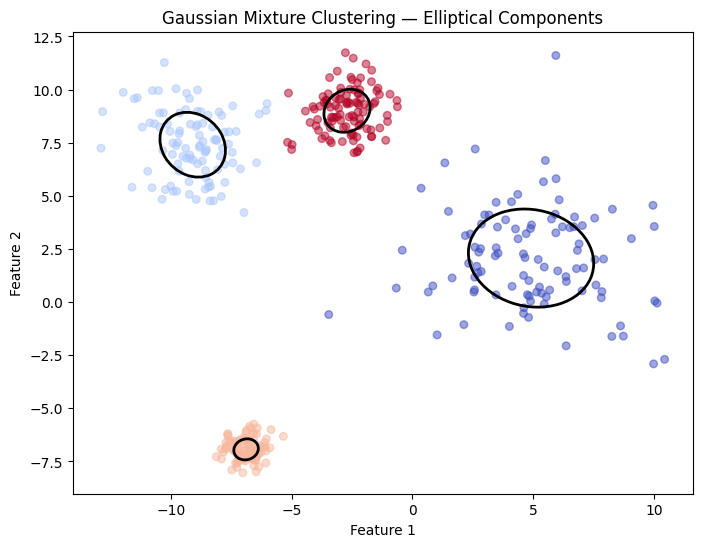

In [25]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

# Generate dataset
X, _ = make_blobs(n_samples=400, centers=4, cluster_std=[1.0, 2.5, 0.5, 1.5], random_state=42)

# Fit Gaussian Mixture
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
gmm.fit(X)
labels = gmm.predict(X)

# Plot points colored by cluster assignment
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='coolwarm', s=30, alpha=0.5)

# Plot ellipses for Gaussian components
for i in range(gmm.n_components):
    mean = gmm.means_[i]
    cov = gmm.covariances_[i]
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:,0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)  # 2 standard deviations
    ell = Ellipse(xy=mean, width=width, height=height, angle=angle,
                  edgecolor='black', facecolor='none', lw=2)  # angle is keyword arg
    plt.gca().add_patch(ell)

plt.title("Gaussian Mixture Clustering — Elliptical Components")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


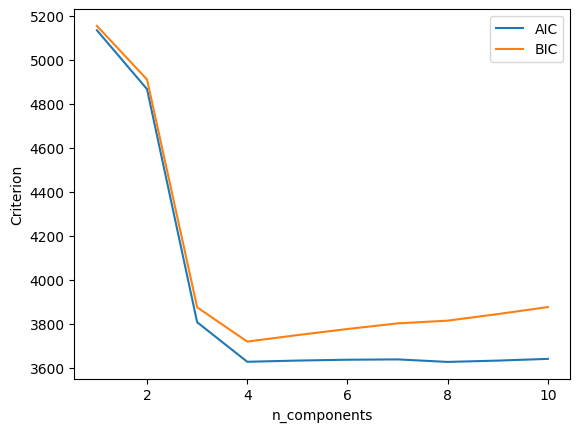

In [26]:
from sklearn.mixture import GaussianMixture

aic = []
bic = []
for k in range(1, 11):
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    aic.append(gmm.aic(X))
    bic.append(gmm.bic(X))

# Plot
import matplotlib.pyplot as plt
plt.plot(range(1, 11), aic, label='AIC')
plt.plot(range(1, 11), bic, label='BIC')
plt.xlabel('n_components')
plt.ylabel('Criterion')
plt.legend()
plt.show()


GMM is a probabilistic, flexible model that can handle overlap, elliptical shapes, and uncertainty — exactly what’s needed in speech, video, and anomaly detection.

### Use-Case: Dynamic Background Subtraction in Videos

**Scenario:**

- You have a video feed of a busy street or outdoor scene.
- Background is **not static**:
  - Trees sway in the wind.
  - Water ripples in a fountain.
  - Shadows and lighting changes occur throughout the day.
- Goal: detect moving objects (cars, pedestrians) as **foreground**, separating them from this complex, dynamic background.

**Why GMM is ideal:**

1. **Each pixel is modeled as a mixture of Gaussians** over time.
   - A pixel on a tree branch might sometimes be dark (shadow) or bright (sunlight).
   - A pixel in a fountain might vary between water, reflections, and splashes.
2. **Soft probabilistic assignment** allows multiple modes per pixel.
   - Unlike K-Means, which assigns each pixel to one fixed cluster, GMM can model **multi-modal distributions** naturally.
3. **Handles noise and outliers**.
   - Small, isolated changes like birds or leaves are treated probabilistically, reducing false positives.

**Impact:**

- Can **reliably detect moving objects in complex, real-world environments** where K-Means or simple thresholding fails.
- Used in **security cameras, traffic monitoring, and robotics**.

![title.png](images/ML_GMM.png)

https://www.youtube.com/watch?v=0nz8JMyFF14